In [0]:
import numpy as np
import cv2
import math


def deskew(orig_image, ench_image, M):
    print('Affine matrix:', M)
    im_out = cv2.warpPerspective(orig_image, np.linalg.inv(M), (ench_image.shape[1], ench_image.shape[0]))
    return im_out
    
def unwarp(orig, ench):
    '''
        Converts original image to shape and crop like enchanced. 
        Needed if you original images in dataset differs from resulted by crop and shape
    '''
    ench_image = cv2.imread(ench, 0)
    orig_image = cv2.imread(orig, 0)
    orig_image_rgb = cv2.imread(orig)

    # here we are using KAZE image descriptor to find similar points on both images.
    try:
        surf = cv2.KAZE_create()
        kp1, des1 = surf.detectAndCompute(ench_image, None)
        kp2, des2 = surf.detectAndCompute(orig_image, None)
    except cv2.error as e:
        print('Error: ', e) 
        print('PASSING')
        return
    

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    # if less then 10 points matched -> not the same images or higly distorted 
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good
                              ]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good
                              ]).reshape(-1, 1, 2)
                              
        # Finds a perspective transformation between two planes. 
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # see https://ch.mathworks.com/help/images/examples/find-image-rotation-and-scale-using-automated-feature-matching.html for details
        ss = M[0, 1]
        sc = M[0, 0]
        scaleRecovered = math.sqrt(ss * ss + sc * sc)
        thetaRecovered = math.atan2(ss, sc) * 180 / math.pi
        print("Calculated scale difference: %.2f\nCalculated rotation difference: %.2f" % (scaleRecovered, thetaRecovered))

        return deskew(orig_image_rgb, ench_image, M)
        
    else:
        print("Not  enough  matches are found   -   %d/%d" % (len(good), MIN_MATCH_COUNT))
        matchesMask = None
        return None


##Unwarp formula
![Unwarp formula](https://docs.opencv.org/2.4/_images/math/fa7e99ae84a2294284e680e2d4c4011121be6492.png)

In [0]:
!wget -q https://github.com/creotiv/computer_vision/raw/master/resources/warp/woman.png
!wget -q https://github.com/creotiv/computer_vision/raw/master/resources/warp/woman_out.png

In [7]:
img = unwarp('woman.png', 'woman_out.png')

Calculated scale difference: 1.18
Calculated rotation difference: 0.08
Affine matrix: [[1.17645504e+00 1.66537238e-03 3.63570668e+01]
 [1.59347278e-02 1.00085505e+00 5.21873273e+01]
 [3.72319752e-04 6.03260643e-06 1.00000000e+00]]


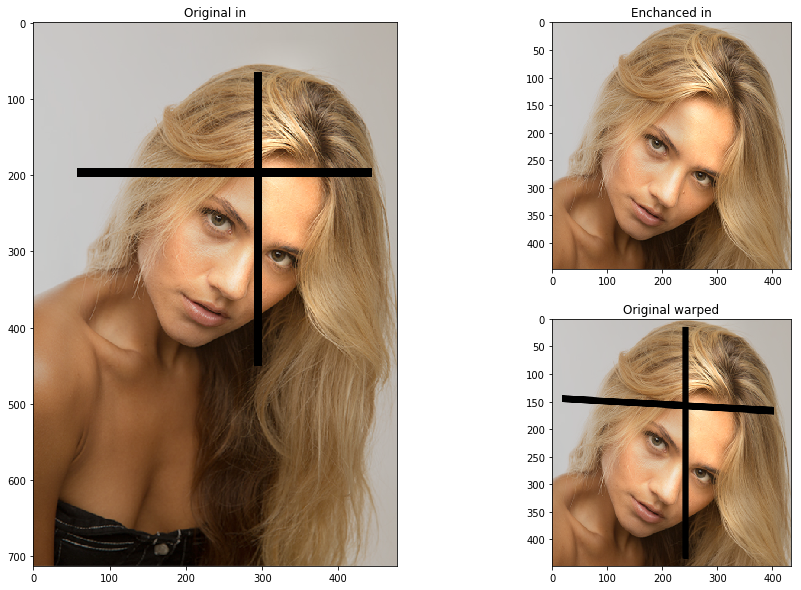

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(121)
ax1.set_title('Original in')
ax1.imshow(cv2.imread('woman.png')[...,::-1])

ax2 = plt.subplot(222)
ax2.imshow(cv2.imread('woman_out.png')[...,::-1])
ax2.set_title('Enchanced in')

ax3 = plt.subplot(224)
ax3.set_title('Original warped')
ax3.imshow(img[...,::-1])

plt.show()
